## Review challenge description

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are asked build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Finding:**   
Based on the description and [Wikipedia](https://en.wikipedia.org/wiki/Lifeboats_of_the_Titanic), people's chances of survival basically depend on whether they got to board the lifeboats before titanic sank.

## Background of this notebook
Two things unusual were found with 'Fare' variable, included in my previous [EDA notebook](https://www.kaggle.com/bofangli/titanic-eda-with-detailed-explanation):
- Almost half of samples' ticket numbers are not unique, which means that many of the passengers share the ticket number with someone else.
-  All three pclasses overlapped in the fare range below 100.

Besides, it was found that the fare is strongly correlated with the pclass (-0.71 with 'Spearman method').

It made me wonder - What causes the overlapping of fares? How to compare the fare values properly? What more information can be extracted from the fare than the pclass? So I'm aiming at these three questions in this notebook.

## Load packages, modules, data and functions

### Load libraries, packages and modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew

### Load the two datasets and combine them
The relationship (family member, wife-husband, child-parent, etc.) among passengers is a potential influential factor for the survival rate. For its analysis, the data of all the passengers needs to put together. So the training data and the testing data will be combined.

In [3]:
#load train data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df

In [4]:
#Get the total number of passengers in the full dataset
len(full_df)

1309

**Finding & analysis:**   
Our full data has 1309 records, one for each passenger. According to [WIKIPEDIA](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) and [HISTORY ON THE NET](https://www.historyonthenet.com/how-many-people-were-on-the-titanic), the total number of Titanic's passengers was 1,317 or 1316. So our full data covers 99% of the passenger population, with only 7 or 8 missing records.

### Fix some data errors and fill in a couple of missing age values

References:   
[Some SibSp/Parch values are wrong](https://www.kaggle.com/c/titanic/discussion/39787)   
[Miss Erna Alexandra Andersson](https://www.encyclopedia-titanica.org/titanic-survivor/erna-andersson.html)   
[Miss Ida Augusta Margareta Andersson](https://www.encyclopedia-titanica.org/titanic-victim/ida-augusta-margareta-andersson.html)

In [5]:
#fix the errors and fill in the missing age values for the Sammann family
indices = [279, 746, 1283, 987, 1188, 48, 920, 13, 610, 119, 541, 542, 813, 850, 68, 1105, 736, 436, 1058, 86, 147]
full_df.loc[279, ['SibSp', 'Parch']]= 0, 2
full_df.loc[1283, ['SibSp', 'Parch']] = 1, 1
full_df.loc[987, 'Age'] = 26
full_df.loc[1188, ['Age', 'SibSp', 'Parch']] = 40, 0, 2
full_df.loc[48, ['Age', 'SibSp', 'Parch']] = 16, 1, 1
full_df.loc[920, ['Age', 'SibSp', 'Parch']] = 18, 1, 1
full_df.loc[68, ['SibSp', 'Parch']] = 0, 0
full_df.loc[1105, ['SibSp', 'Parch']] = 0, 0
full_df.loc[736, ['SibSp', 'Parch']] = 0, 4
full_df.loc[[436, 1058, 86, 147], ['SibSp', 'Parch']] = 3, 1

## Fare sharing among passengers?
According to [encyclopedia-titanic](https://www.encyclopedia-titanica.org/), I found that the passengers sharing the ticket numbers ( I refer them to a ticket group) might share the ticket fares as well, which means that the fare is actually the total fare for them.[LeonardFI](https://www.kaggle.com/c/titanic/discussion/3916) found it too.   

The fare values are to be analyzed from these perspecitves:
- What is the distribution of the ticekt-group-size values?
- Are the fare values of the same ticket group the same?
- Do the fare values increase with the increase in the ticket group size?
- Is there less fare overlapping between pclasses for the samples with ticket group size of 1?
- Are the fare max/medium ratios much smaller?

### What is the distribution of the ticekt-group-size values?

In [6]:
#group the samples by the ticket numbers and count each group
ticket_group_sizes = full_df.groupby('Ticket').size()

#create a new feature 'Ticket_group_size'    
full_df['Ticket_group_size'] = full_df['Ticket'].apply(lambda x: ticket_group_sizes[x])

In [7]:
#check the distribution of Ticket_group_size
ticket_group_sizes = full_df['Ticket_group_size'].value_counts()
ticket_group_percentages = round(full_df['Ticket_group_size'].value_counts()/len(full_df)*100)
ticket_groups = pd.concat([ticket_group_sizes, ticket_group_percentages], axis=1)
ticket_groups.columns = ['Quantity', 'Percentage']
ticket_groups

,Quantity,Percentage
1,713,54.0
2,264,20.0
3,147,11.0
4,64,5.0
7,35,3.0
5,35,3.0
6,24,2.0
8,16,1.0
11,11,1.0


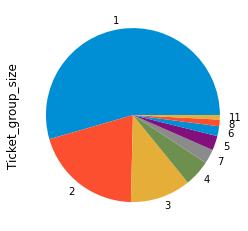

In [8]:
ticket_group_sizes.plot.pie();

**Finding:**   
Half of the passengers had unique ticket numbers.   
The rest passengers were mainly in the ticket groups of 2 or 3 people.  

### Are the fare values of the same ticket group the same?

In [9]:
#check whether the fare values within each ticket group are the same
are_fares_different = full_df.groupby('Ticket').Fare.nunique() > 1
are_fares_different[are_fares_different].index.tolist()

['7534']

In [10]:
full_df[full_df['Ticket']=='7534']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
138,139,0.0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,1,2
876,877,0.0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S,1,2


**Finding:**  
Within each ticket group, the fare values are exactly the same. There's only one exception - ticket '7534'.   
The two fare values of ticket '7534' are slightly different (9.2167, 9.8458).  
[Geni](https://www.geni.com/people/Olaf-Elon-Os%C3%A9n/6000000015915621723) mentions that Mr. Olaf Elon Osen	travelled with Mr Alfred Ossian Gustafsson on titanic.

### Do the fare values increase with the increase in the ticket group size?

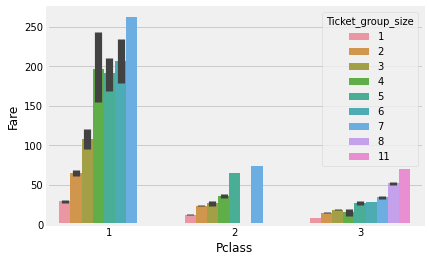

In [11]:
sns.barplot(x='Pclass', y='Fare', hue='Ticket_group_size', data=full_df);

**Finding:**   
In general , within each pclass, the fare values tend to increase with the ticket group sizes.   
In pclass1, the variations of fare values for ticket group sizes 3~6 are relatively big.

### Is there less fare overlapping between pclasses for the samples with ticket group size of 1?

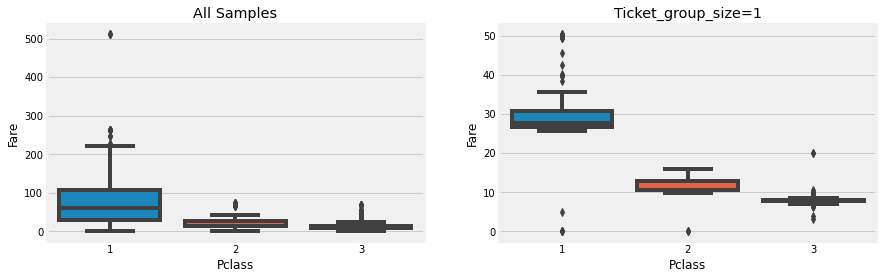

In [12]:
#plot the distributions of fares across pclasses
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(right = 2)
#plot for all the samples, on the left
sns.boxplot(x='Pclass', y='Fare', data=full_df, ax=ax[0]);
ax[0].set_title('All Samples')
#plot only for the samples of Ticket_group_size value of 1, on the right
tickets_not_shared = full_df['Ticket_group_size']==1
sns.boxplot(x='Pclass', y='Fare', data=full_df[tickets_not_shared], ax=ax[1])
ax[1].set_title('Ticket_group_size=1');

**Finding:**   
The fare scale (500) of the left subplot is 10 times as big as that (50) of the right one.
For all the samples, the fare range of each pclass is big and they much overlap below 100.   
For the samples with ticket group size of 1, the fare range is much smaller in each pclass and there's little overlapping of fare values between pclasses. Besides,some outliers are more noticeable and they will be further analyzed next

### Analyze the outliers in the samples of unique ticket numbers

During the analysis of the samples of unique ticket numbers (ticket group size of 1), some outliers were noticed. They may be wrong data and had better be checked.

As described in my previous [EDA](https://www.kaggle.com/bofangli/titanic-eda-with-detailed-explanation), some tickets were complimentary (fare value=0).   
According to [Tammy Keefer](https://www.kaggle.com/c/titanic/discussion/10570), one of those passengers who had the complimentary tickets was the employee.

In [13]:
#Locate the record of the Pclass1 ticket of which the fare is far below the median
fare_between_one_ten = (full_df.Fare < 10) & (full_df.Fare > 1) 
full_df[tickets_not_shared & (full_df.Pclass==1) & fare_between_one_ten]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
872,873,0.0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,1,1


**Search online about the ticket fare of Mr. Frans:**   
According to [Geni](https://www.geni.com/people/Frans-Olof-Carlsson-1st-Class-RMS-Titanic-Casualty/6000000015948569078), Mr. Frans' ticket fare was indeed  £5. But he was the employee.

In [14]:
#Locate the record of the Pclass1 ticket of which the fare is far above the median
full_df[tickets_not_shared & (full_df.Pclass==1) & (full_df.Fare > 50)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
867,868,0.0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,1,1
1057,1058,NaN,1,"Brandeis, Mr. Emil",male,48.0,0,0,PC 17591,50.4958,B10,C,0,1


**Search online about the ticket fare of Mr. Washington:**  
As [Encyclopedia-titanica](https://www.encyclopedia-titanica.org/titanic-victim/washington-roebling.html) mentions, Mr. Washington carried ticket no. PC 17590 (£50 9s 11d). So the high value around 50 was confirmed.

In [15]:
#Locate the record of the Pclass3 ticket of which the fare is far above the median
full_df[tickets_not_shared & (full_df.Pclass==3) & (full_df.Fare > 15)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S,1,1
490,491,0.0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S,1,1


**Search online about the ticket fares of Mr. Ingvald and Mr. Konrad**   
As [Encyclopedia-titanica ](https://www.encyclopedia-titanica.org/titanic-victim/ingvald-olai-olsen-hagland.html) mentions, Mr. Ingvald was the brother in law of Mr. Konrad and their ticket fares were £6, 19s, 4d, within the normal fare range of Pclass 3. So their fare values in our data are wrong and should be 6.9667.
<a id="wrong_fares"></a>

In [16]:
#Correct the two wrong fare values
full_df.loc[[451, 490], 'Fare'] = 6.9667
full_df.loc[[451, 490]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,6.9667,NaN,S,1,1
490,491,0.0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,6.9667,NaN,S,1,1


### Are the fare max/medium ratios much smaller?

In [17]:
#obtain descriptive statistics of fares at different pclasses for the samples of Ticket_group_size value of 1
fares_by_pclasses = {}

for i in range(1,4):
    fares_by_pclasses[i]=full_df.loc[tickets_not_shared & (full_df.Pclass==i), 'Fare'].describe()
    
fares_by_pclasses_df = pd.concat([v[1] for v in fares_by_pclasses.items()], axis=1)
fares_by_pclasses_df.columns=['Pclass ' + str(i) for i in range(1, 4)]
print("Fares' distribution in each Pclass:")
display(fares_by_pclasses_df)

Fares' distribution in each Pclass:


,Pclass 1,Pclass 2,Pclass 3
count,106.000000,136.000000,470.000000
mean,29.113715,12.176285,7.834636
std,9.518051,2.295573,0.665863
min,0.000000,0.000000,3.170800
25%,26.550000,10.500000,7.629200
50%,27.720800,13.000000,7.829200
75%,30.695800,13.000000,8.050000
max,50.495800,16.000000,10.516700


**Finding:**   
Two fare errors were found and corrected. They were mentioned in my previous [EDA notebook](https://www.kaggle.com/bofangli/titanic-eda-with-detailed-explanation).
That notebook shows that the max/median fare ratios of three pclasses of all samples are unusally big, 5~9.   
For the samples of Ticket_group_size value of 1, the ratios are much smaller, only 1.2~1.8.

**Finding and analysis on fare-sharing possibility:**   
Are the fare values of the same ticket group the same? Yes.   
Do the fare values increase with the increase in the ticket group size? Yes.   
Is there less fare overlapping between pclasses for the samples with ticket group size of 1? Yes.  
Are the fare max/medium ratios much smaller? Yes.   

With these evidences, the possibility is high that half of the titanic passengers shared the fares. My further analysis will be based on this assumption until some new evidence proves it wrong. In this case, each fare value is not the fare of the individual passengers, but the total fare of the ticket group.The direct comparison of fare values can be misleading.   

How to treat the fare variable to avoid misleading? Can we just drop fare due to its strong correlation with pclass?

## What more information can be extracted from the fare than the pclass? 

### Correlation between fare and pclass with the removal of the fare-sharing influence

In [18]:
# What's the correlation between fare and pclass for the samples of Ticket_group_size value of 1
round(full_df.loc[tickets_not_shared, ['Fare', 'Pclass']].corr('spearman').iloc[0,1], 2)

-0.77

**Finding and analysis:**   
With the removal of the fare-sharing influence, the correlation between fare and pclass gets stronger by 8%, from -0.71 to -0.77.    
   
In this challenge, we are asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). Pclass stands for the socio-economic class. Is the fare subclass of socio-economic class? No such information is included in the data or description provided by Kaggle. So external data is necessary for clarification. 

### Are there any subclasses of each pclass with different prices?

[Wikipedia](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) says,   
'**The ship's passengers were divided into three separate classes determined by the price of their ticket:** those travelling in first class, most of them the wealthiest passengers on board, included prominent members of the upper class, businessmen, politicians, high-ranking military personnel, industrialists, bankers, entertainers, socialites, and professional athletes. Second-class passengers were predominantly middle-class travellers and included professors, authors, clergymen, and tourists. Third-class or steerage passengers were primarily immigrants moving to the United States and Canada.'

**Fare table** based on Wikipedia[1](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) [2](https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic)

|Accommodation|Price|
| :- | -: | 
|First-class more lavish and opulent parlor suite|	£500-1000|
|First-class smaller parlor suite|	£100-300|
|Berth in first-class standard cabin| £30 |
|Berth in second-class cabin| £12 (average)|
|Berth in third-class cabin| £3 for children, £7 (average) for adults|


Wikipedia[1](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) also mentions, "Third-class passengers paid £7 (£698 today) for their ticket, depending on their place of origin; ticket prices often included the price of rail travel to the three departure ports".

[Encyclopedia](https://www.encyclopedia-titanica.org/community/threads/children-on-the-titanic.20096/) mentions,Titanic's Certificates for Clearance defined **the children as under age 12**, age 12 and upwards were counted as adults.

In [19]:
#Look for children with uniuqe ticket number and check if their fare was around 3
full_df[tickets_not_shared & (full_df.Age <12)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
912,913,NaN,3,"Olsen, Master. Artur Karl",male,9.0,0,1,C 17368,3.1708,NaN,S,0,1


**Finding and analysis:**   
The second class and third class had no subclasses.   
The third class' fares' variation was related with the place of origin (ticket prices often included the price of rail travel to the three departure ports) and the children fee.

The first class had three separate price ranges: **£500-1000** for lavish parlor suite, **£100-300** for smaller parlor suite,  **£30** for cabin.The pclass1 fare values will be further analyzed next.

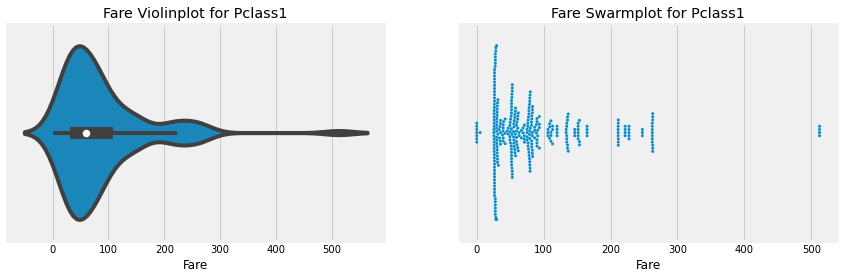

In [20]:
#plot the distributions of fares of pclass1, violinplot (left), swarmplot(right)
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(right = 2)
#Fare distribution by violinplot
sns.violinplot(x='Fare', data=full_df[full_df.Pclass==1], ax=ax[0]);
ax[0].set_title('Fare Violinplot for Pclass1')
# Fare distribution by swarmplot in which every data point is displayed
sns.swarmplot(x='Fare', size=3, data=full_df[full_df.Pclass==1], ax=ax[1]);
ax[1].set_title('Fare Swarmplot for Pclass1');

**Finding and analysis:**
From the violinplot on the left, we find that there are three peaks (~30, ~230, over 500) and hence the distribution has three modes. The majority of the data points belong to the first distribution, and very few of them belong to the third distribution.The number of modes are consistent with the number of price ranges, both are three. 
Besides, there's a big gap between the second distribution and the third, consistent with the wikipedia fare information.   
However, there is no clear gap between the first distribution and the second. The fare values of non-free pclass1 tickets below 100 was expected to be the same or very close, around 30 while the swarmplot shows that most of the data points are scattered between 30~100. This big conflict needs to be clarified with external information. 

[Ultimatetitanic](https://www.ultimatetitanic.com/interior-fittings) says, "If a parlor suite didn’t suffice, a wealthy family could purchase several first-class cabins adjacent to one another and open the interconnecting doors between the cabins to have a suite of their own". So standard cabins were not necessarily of low subclass than smaller parlor suites. 

In [21]:
full_df[full_df.Fare>500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
258,259,1.0,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,1,4
679,680,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,1,4
737,738,1.0,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,1,4
1234,1235,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,0,4


**Finding:**   
Only four passengers' fares were above 500 - 2 male (both survived) and 2 female (one survived, one unknown from the data), of the same ticket number.These males' survival rate were higher than the rest pclass1 male passengers.   
The previous [EDA notebook](https://www.kaggle.com/bofangli/titanic-eda-with-detailed-explanation) shows that for pclass1, less than 40% males survived and almost all females survived.
The samples of small size are susceptible to randomness. No reliable conclusions can be made just based on the data analysis of such few samples (only 4). Exteral evidence is necessary to prove that these top pclass1 passengers (esp. men) were given higher priority to board the lifeboat.

**Online search for these four top pclass1 passengers:**   
[Titanicpages](https://www.titanicpages.com/thomascardeza) says that Thomas Cardeza, his mother, and their servants boarded lifeboat 3 and survived.   

According to [Wikipedia](https://en.wikipedia.org/wiki/Lifeboats_of_the_Titanic), lifeboat 3 was the third to be lowered from the **starboard** side.One very important clue was found there: the men's chances of survival largely depend on which side of the ship the men tried to find lifeboat seats. Captain Smith ordered his officers to put the "women and children in and lower away".However, **Murdoch and Lightoller interpreted the evacuation order differently: Murdoch (in charge of starboard side) as women and children first, while Lightoller (port side) as women and children only**.   

If the family of Thomas Cardeza had tried to find lifeboat seats from the port side, Thomas and his manservant might have not been able to access the lifeboat.

So I did not find any strong evidence that the top pclass1 passengers (fare >500) were given higher priority to board the life boat than the rest pclass1 passengers.

**Conclusion:**   
The second class and third class had no subclasses.   
Pclass1 did have subclasses. Though pclass1 had three separate price ranges, there were only two fare ranges clearly separated - above 500, and below 300.   
Among the pclass1 passengers, the four passengers (esp. men) of the first subclass (fare >500) had a much higher survival rate than those of the second subclass. However, due to the small sample size, this finding is very much susceptible to randomness, which is supported by the external resources.

### Is the special fare (zero and unusually low) related with the survival rate?

My previous [EDA notebook](https://www.kaggle.com/bofangli/titanic-eda-with-detailed-explanation) and the fare outliers analysis of this notebook show that there were some free tickets and one very cheap pclass1 ticket of £5.

In [22]:
print("There were {} free tickets.".format(len(full_df[full_df.Fare==0])))
full_df[full_df.Fare==0].sort_values(by=['Pclass', 'Ticket'])

There were 17 free tickets.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
806,807,0.0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,1,1
1157,1158,NaN,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S,0,1
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1,1
815,816,0.0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S,1,2
1263,1264,NaN,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S,0,2
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1,1
822,823,0.0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,1,1
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1,3
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1,3
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1,3


In [23]:
#Pclass values of the passengers with free tickets
full_df[full_df.Fare==0].Pclass.value_counts()

1    7
2    6
3    4
Name: Pclass, dtype: int64

In [34]:
#Survival status of the passengers with free tickets
full_df[full_df.Fare==0].Survived.value_counts()

0.0    14
1.0     1
Name: Survived, dtype: int64

In [33]:
#Survival rates of males of three Pclasses
full_df[full_df.Sex=='male'].groupby('Pclass')['Survived'].mean()

Pclass
1    0.368852
2    0.157407
3    0.135447
Name: Survived, dtype: float64

**Finding:**   
As mentioned above in [outlier analysis](#Analyze-the-outliers-in-the-samples-of-unique-ticket-numbers), Mr. Frans' pclass1 ticket fare was £5, and he was the employee and died during the titanic voyage.

Among these 17 passengers with complimentary tickets and another passenger with a very cheap pclass1 ticket:   
- 8 of Pclass1, 6 of Pclass2, 4 of Pclass3.   
- 15 died, 1 survived (Pclass3), 2 unknown survival status (Pclass1) from the data.

The survival status of 16 out of them are known from the data. Among these 16 passengers:
- Pclass1: 6 totally, all died. Their survival rates was lower than those of Pclass1 male passengers on average.
- Pclass2: 6 totally, all died. The sample size is not big enough for comparison because the survival rate was only 0.16 on average.
- Pclass3: 4 totally, only 1 survived. The survival rate was higher than those of Pclass1 male passengers on average.
- Survival rate: 6% (1 out of 16).

**Finding from online search for the reasons behind the free or low-price tickets:**   
Among the owners of complementary tickets:   
All second-class （six totally) and three first-class passengerss(passengerIds 264, 807, 1158) belonged to [The nine-strong "guarantee group"](https://maritimebelfast.com/case-studies/titanic-heritage-plaques-the-guarantee-group/) of Harland and Wolff employees chosen to oversee the smooth running of the Titanic's maiden voyage.   
All third-class (four totally) were [American Line employee](https://www.geni.com/people/Lionel-Leonard/6000000016211210238).   
[Naval architect](https://en.wikipedia.org/wiki/Thomas_Andrews) that was in charge of the plans for the ocean liner RMS Titanic: Thomas_Andrews(807).
Other first-class:   
- [Chairman and managing director of the White Star Line]((https://en.wikipedia.org/wiki/J._Bruce_Ismay): Ismay, Mr. Joseph Bruce(1264).
- [His valet (816) and secretary (634)](https://www.geni.com/people/John-Richard-Fry/6000000016142357235) 
- Reuchlin, Jonkheer. John George (823), his ticket was complementary because of his position with the Holland America Line which was part of the International Mercantile according to [geni](https://www.geni.com/people/Jonkheer-Johan-George-Reuchlin/6000000015519745032)

[Wikipedia](https://en.wikipedia.org/wiki/Crew_of_the_Titanic) says that the nine-member Guarantee Group and the eight members of the ship's band, who were given passenger accommodations and treated as both passengers and crew.

**Crew statistics of [Titanicfacts](https://titanicfacts.net/titanic-crew/):**    
There were Totally 908 crew members on board the RMS Titanic.Among them, 212 survived (23%).
885 crew members were male and 192 out of them survived (22%).

**Conclusion:**   
The owners of the special fare (zero and unusually low) were the male employees of RMS titanic or related companies. They were not treated as both passengers and crew.    
Their survival rate (6%) was much lower than that of the male crew (22%) and that of the male passengers (19%). However, as the sample size is so small, their observations were susceptible to randomness and hence the reliability of the analysis result is compromised.

### Ticket group indication?

In [48]:
#Number of unique ticket values of each fare group
tickets_in_fareGroups = full_df.groupby('Fare')['Ticket'].nunique()

In [53]:
#How many fare groups have more than one ticket values
np.sum(tickets_in_fareGroups>1)

90

**Finding:**   
Fares can't be used as the indication for ticket groups because the tickets of same fares are not necessarily of the same number.

## Summary

- The overlapping of fares were mainly caused by the sharing of fares. 46% fare values are not of the individual, but of the ticket group.   
- The direct comparison of fare values can be misleading.  
- The Fare variable is strongly coorelated with the Pclass variable which is the indication of socio-economic class.
- Some additional information can be extracted from fare values: 
    - Subclass of Pclass1. Pclass2 and Pclass3 had no subclasses. Pclass1 had at least two subclasses.   
    - Special passengers (including the nine-member Guarantee Group and the eight members of the ship's band) who had free tickets and another employee with £5 pclass1 ticket.   